# CIFAR-10 Dropout test using CNN

####Install Theano

In [0]:
pip install -U git+https://github.com/Theano/Theano.git#egg=Theano

  Cloning https://github.com/Theano/Theano.git to /tmp/pip-install-orl7vwm3/Theano
  Running command git clone -q https://github.com/Theano/Theano.git /tmp/pip-install-orl7vwm3/Theano
  Created wheel for Theano: filename=Theano-1.0.4+12.g93e8180bf-cp36-none-any.whl size=2667476 sha256=36434006d2fc766e6cfec28a2fc6a4b6f4fc22d461b2f156815566cf63e7bdba
  Stored in directory: /tmp/pip-ephem-wheel-cache-sb5lk15w/wheels/14/72/17/35fc1366380e8e05fc8ed5d44e24a2da28ef975aa4be6aaa17
Successfully built Theano
  Found existing installation: Theano 1.0.4
    Uninstalling Theano-1.0.4:
      Successfully uninstalled Theano-1.0.4


#### Import Package

In [0]:
import numpy as np
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda*,floatX=float32"
import theano
import keras

from keras.datasets import cifar10
from keras.models  import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

## Train on CIFAR-10 dataset

#### Load CIFAR 10 dataset.

CIFAR-10은 총 10개의 레이블로 이루어진 6만장의 이미지를 가지고 있으며 5만장은 트레이닝, 1만장은 테스트 용도로 쓰입니다. 해당 데이터셋은 http://www.cs.toronto.edu/~kriz/cifar.html 에서 다운로드 받으실 수 있습니다.

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print ("Training data:")
print ("Number of examples: ", X_train.shape[0])
print ("Number of channels:",X_train.shape[3]) 
print ("Image size:", X_train.shape[1], X_train.shape[2])
print
print ("Test data:")
print ("Number of examples:", X_test.shape[0])
print ("Number of channels:", X_test.shape[3])
print ("Image size:", X_test.shape[1], X_test.shape[2]) 

print(X_train.shape, X_train.dtype)

170500096/170498071 [==============================] - 2s 0us/step
Training data:
Number of examples:  50000
Number of channels: 3
Image size: 32 32
Test data:
Number of examples: 10000
Number of channels: 3
Image size: 32 32
(50000, 32, 32, 3) uint8


#### Visualize some images from CIFAR-10 dataset. 
CIFAR-10 데이터셋은 다음의 10가지 클래스를 담고 있습니다.  
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

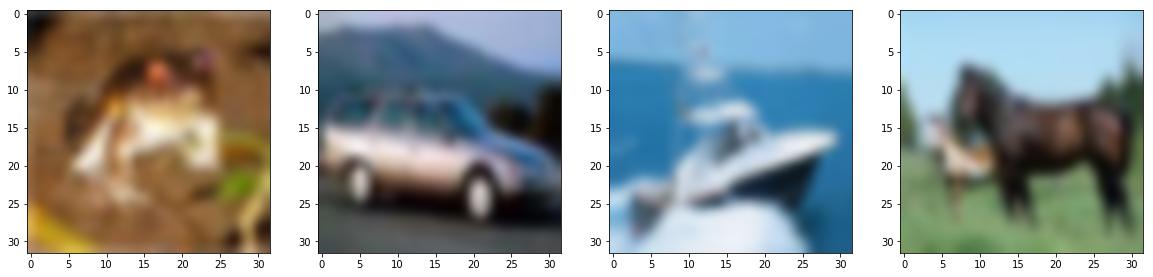

In [0]:
plt.subplot(141)
plt.imshow(X_train[0], interpolation="bicubic")
plt.grid(False)
plt.subplot(142)
plt.imshow(X_train[4], interpolation="bicubic")
plt.grid(False)
plt.subplot(143)
plt.imshow(X_train[8], interpolation="bicubic")
plt.grid(False)
plt.subplot(144)
plt.imshow(X_train[12], interpolation="bicubic")
plt.grid(False)
plt.show()

#### Normalize the data.

In [0]:
print ("mean before normalization:", np.mean(X_train)) 
print ("std before normalization:", np.std(X_train))

mean=[0,0,0]
std=[0,0,0]
newX_train = np.ones(X_train.shape)
newX_test = np.ones(X_test.shape)
for i in range(3):
    mean[i] = np.mean(X_train[:,:,:,i])
    std[i] = np.std(X_train[:,:,:,i])
    
for i in range(3):
    newX_train[:,:,:,i] = X_train[:,:,:,i] - mean[i]
    newX_train[:,:,:,i] = newX_train[:,:,:,i] / std[i]
    newX_test[:,:,:,i] = X_test[:,:,:,i] - mean[i]
    newX_test[:,:,:,i] = newX_test[:,:,:,i] / std[i]
        
    
X_train = newX_train
X_test = newX_test

print ("mean after normalization:", np.mean(X_train))
print ("std after normalization:", np.std(X_train))
print(X_train.max())


mean before normalization: 120.70756512369792
std before normalization: 64.1500758911213
mean after normalization: 4.91799193961621e-17
std after normalization: 0.9999999999999996
2.126789409516928


#### Specify Training Parameters

In [0]:
batchSize = 512                   #-- Training Batch Size
num_classes = 10                  #-- Number of classes in CIFAR-10 dataset
num_epochs = 50                   #-- Number of epochs for training   
learningRate= 0.001               #-- Learning rate for the network
lr_weight_decay = 0.95            #-- Learning weight decay. Reduce the learn rate by 0.95 after epoch


img_rows = 32                     #-- input image dimensions
img_cols = 32 

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

#### VGGnet-10

In [0]:
from keras import initializers
import copy
result = {}
y = {}
loss = []
acc = []
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for dropout in dropouts:
    print ("Dropout: ", (dropout))
    model = Sequential()

    #-- layer 1
    model.add(Conv2D(64, 3, 3,
                            border_mode='same',
                            input_shape=(img_rows, img_cols,3)))
    model.add(Dropout(dropout))  
    model.add(Conv2D(64, 3, 3, activation='relu',border_mode='same'))
    model.add(Dropout(dropout))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ##--layer 2
    model.add(Conv2D(128, 3, 3, activation='relu',border_mode='same'))
    model.add(Dropout(dropout))                                        
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ##--layer 3                         
    model.add(Conv2D(256, 3, 3, activation='relu',border_mode='same'))
    model.add(Dropout(dropout)) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ##-- layer 4
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))

    #-- layer 5
    model.add(Dense(512, activation='relu'))

    #-- layer 6
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    
    model_cce = model.fit(X_train, Y_train, batch_size=batchSize, nb_epoch=num_epochs, verbose=1, shuffle=True, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    y[dropout] = model.predict(X_test)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    result[dropout] = copy.deepcopy(model_cce.history)   
    loss.append(score[0])
    acc.append(score[1])
    

Dropout:  0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 15s 303us/step - loss: 1.9385 - acc: 0.2966 - val_loss: 1.5588 - val_acc: 0.4490
Epoch 2/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.5031 - acc: 0.4626 - val_loss: 1.2654 - val_acc: 0.5518
Epoch 3/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.2137 - acc: 0.5729 - val_loss: 1.2553 - val_acc: 0.5711
Epoch 4/50
50000/50000 [==============================] - 8s 164us/step - loss: 0.9973 - acc: 0.6553 - val_loss: 0.9407 - val_acc: 0.6793
Epoch 5/50
50000/50000 [==============================] - 8s 164us/step - loss: 0.8211 - acc: 0.7162 - val_loss: 0.8559 - val_acc: 0.7133
Epoch 6/50
50000/50000 [==============================] - 8s 164us/step - loss: 0.6732 - acc: 0.7657 - val_loss: 0.9931 - val_acc: 0.6740
Epoch 7/50
50000/50000 [==============================] - 8s 161us/step - loss: 0.5594 - acc: 0.8056 - val_loss: 0.8078 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 336us/step - loss: 1.9821 - acc: 0.2834 - val_loss: 1.6872 - val_acc: 0.4009
Epoch 2/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.5218 - acc: 0.4593 - val_loss: 1.3310 - val_acc: 0.5359
Epoch 3/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.2657 - acc: 0.5543 - val_loss: 1.0718 - val_acc: 0.6295
Epoch 4/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.0296 - acc: 0.6406 - val_loss: 0.9799 - val_acc: 0.6700
Epoch 5/50
50000/50000 [==============================] - 12s 238us/step - loss: 0.8548 - acc: 0.7033 - val_loss: 0.8980 - val_acc: 0.6890
Epoch 6/50
50000/50000 [==============================] - 12s 237us/step - loss: 0.7198 - acc: 0.7503 - val_loss: 0.7887 - val_acc: 0.7275
Epoch 7/50
50000/50000 [==============================] - 12s 237us/step - loss: 0.5871 - acc: 0.7946 - val_loss: 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 338us/step - loss: 1.9621 - acc: 0.2964 - val_loss: 1.7298 - val_acc: 0.4124
Epoch 2/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.5175 - acc: 0.4557 - val_loss: 1.4879 - val_acc: 0.4757
Epoch 3/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.2832 - acc: 0.5497 - val_loss: 1.2349 - val_acc: 0.5902
Epoch 4/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.0668 - acc: 0.6278 - val_loss: 0.9899 - val_acc: 0.6679
Epoch 5/50
50000/50000 [==============================] - 12s 236us/step - loss: 0.9104 - acc: 0.6843 - val_loss: 0.9987 - val_acc: 0.6583
Epoch 6/50
50000/50000 [==============================] - 12s 237us/step - loss: 0.7734 - acc: 0.7325 - val_loss: 1.0436 - val_acc: 0.6485
Epoch 7/50
50000/50000 [==============================] - 12s 238us/step - loss: 0.6353 - acc: 0.7799 - val_loss: 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 342us/step - loss: 1.9732 - acc: 0.2927 - val_loss: 1.8790 - val_acc: 0.3888
Epoch 2/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.5620 - acc: 0.4461 - val_loss: 1.5758 - val_acc: 0.4999
Epoch 3/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.3236 - acc: 0.5347 - val_loss: 1.3234 - val_acc: 0.5851
Epoch 4/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.1238 - acc: 0.6096 - val_loss: 1.2428 - val_acc: 0.6092
Epoch 5/50
50000/50000 [==============================] - 12s 237us/step - loss: 0.9700 - acc: 0.6642 - val_loss: 1.0913 - val_acc: 0.6615
Epoch 6/50
50000/50000 [==============================] - 12s 237us/step - loss: 0.8339 - acc: 0.7131 - val_loss: 0.9703 - val_acc: 0.7012
Epoch 7/50
50000/50000 [==============================] - 12s 238us/step - loss: 0.7214 - acc: 0.7490 - val_loss: 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 342us/step - loss: 1.9997 - acc: 0.2884 - val_loss: 1.9254 - val_acc: 0.4007
Epoch 2/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.5902 - acc: 0.4333 - val_loss: 1.7251 - val_acc: 0.4702
Epoch 3/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.3669 - acc: 0.5156 - val_loss: 1.5500 - val_acc: 0.5617
Epoch 4/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.1840 - acc: 0.5838 - val_loss: 1.3550 - val_acc: 0.6393
Epoch 5/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.0367 - acc: 0.6374 - val_loss: 1.1425 - val_acc: 0.6738
Epoch 6/50
50000/50000 [==============================] - 12s 235us/step - loss: 0.9155 - acc: 0.6824 - val_loss: 1.0711 - val_acc: 0.7008
Epoch 7/50
50000/50000 [==============================] - 12s 233us/step - loss: 0.8088 - acc: 0.7192 - val_loss: 1.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 340us/step - loss: 2.0862 - acc: 0.2767 - val_loss: 2.0337 - val_acc: 0.3880
Epoch 2/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.6168 - acc: 0.4254 - val_loss: 1.7986 - val_acc: 0.5060
Epoch 3/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.4177 - acc: 0.4965 - val_loss: 1.6215 - val_acc: 0.5469
Epoch 4/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.2735 - acc: 0.5545 - val_loss: 1.4934 - val_acc: 0.5904
Epoch 5/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.1169 - acc: 0.6096 - val_loss: 1.3729 - val_acc: 0.6269
Epoch 6/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.0023 - acc: 0.6513 - val_loss: 1.3111 - val_acc: 0.5977
Epoch 7/50
50000/50000 [==============================] - 12s 232us/step - loss: 0.8800 - acc: 0.6938 - val_loss: 1.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 355us/step - loss: 2.1751 - acc: 0.2530 - val_loss: 2.1588 - val_acc: 0.3571
Epoch 2/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.6971 - acc: 0.3953 - val_loss: 2.0750 - val_acc: 0.3496
Epoch 3/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.5079 - acc: 0.4612 - val_loss: 1.8759 - val_acc: 0.4861
Epoch 4/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.3660 - acc: 0.5155 - val_loss: 1.7812 - val_acc: 0.4920
Epoch 5/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.2426 - acc: 0.5605 - val_loss: 1.7786 - val_acc: 0.5080
Epoch 6/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.1377 - acc: 0.5982 - val_loss: 1.5276 - val_acc: 0.6198
Epoch 7/50
50000/50000 [==============================] - 12s 233us/step - loss: 1.0401 - acc: 0.6367 - val_loss: 1.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 356us/step - loss: 2.7049 - acc: 0.1948 - val_loss: 2.2286 - val_acc: 0.2705
Epoch 2/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.8397 - acc: 0.3398 - val_loss: 2.1806 - val_acc: 0.2636
Epoch 3/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.6723 - acc: 0.4032 - val_loss: 2.0388 - val_acc: 0.4005
Epoch 4/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.5296 - acc: 0.4544 - val_loss: 2.0112 - val_acc: 0.3564
Epoch 5/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.4332 - acc: 0.4886 - val_loss: 1.9227 - val_acc: 0.4107
Epoch 6/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.3466 - acc: 0.5221 - val_loss: 1.8196 - val_acc: 0.4989
Epoch 7/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.2564 - acc: 0.5522 - val_loss: 1.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 359us/step - loss: 14.4250 - acc: 0.1003 - val_loss: 3.3239 - val_acc: 0.1000
Epoch 2/50
50000/50000 [==============================] - 12s 233us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 3.3239 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 12s 234us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 3.3239 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 12s 234us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 3.3239 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 12s 233us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 3.3239 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 12s 232us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 3.3239 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 12s 232us/step - loss: 14.5063 - acc: 0.1000 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 362us/step - loss: 14.5033 - acc: 0.1000 - val_loss: 2.4779 - val_acc: 0.1000
Epoch 2/50
50000/50000 [==============================] - 12s 234us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 2.5704 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 12s 234us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 2.5704 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 12s 234us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 2.5704 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 12s 234us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 2.5704 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 12s 232us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 2.5704 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 12s 232us/step - loss: 14.5063 - acc: 0.1000 - val_l

#### example

## Plotting Results.

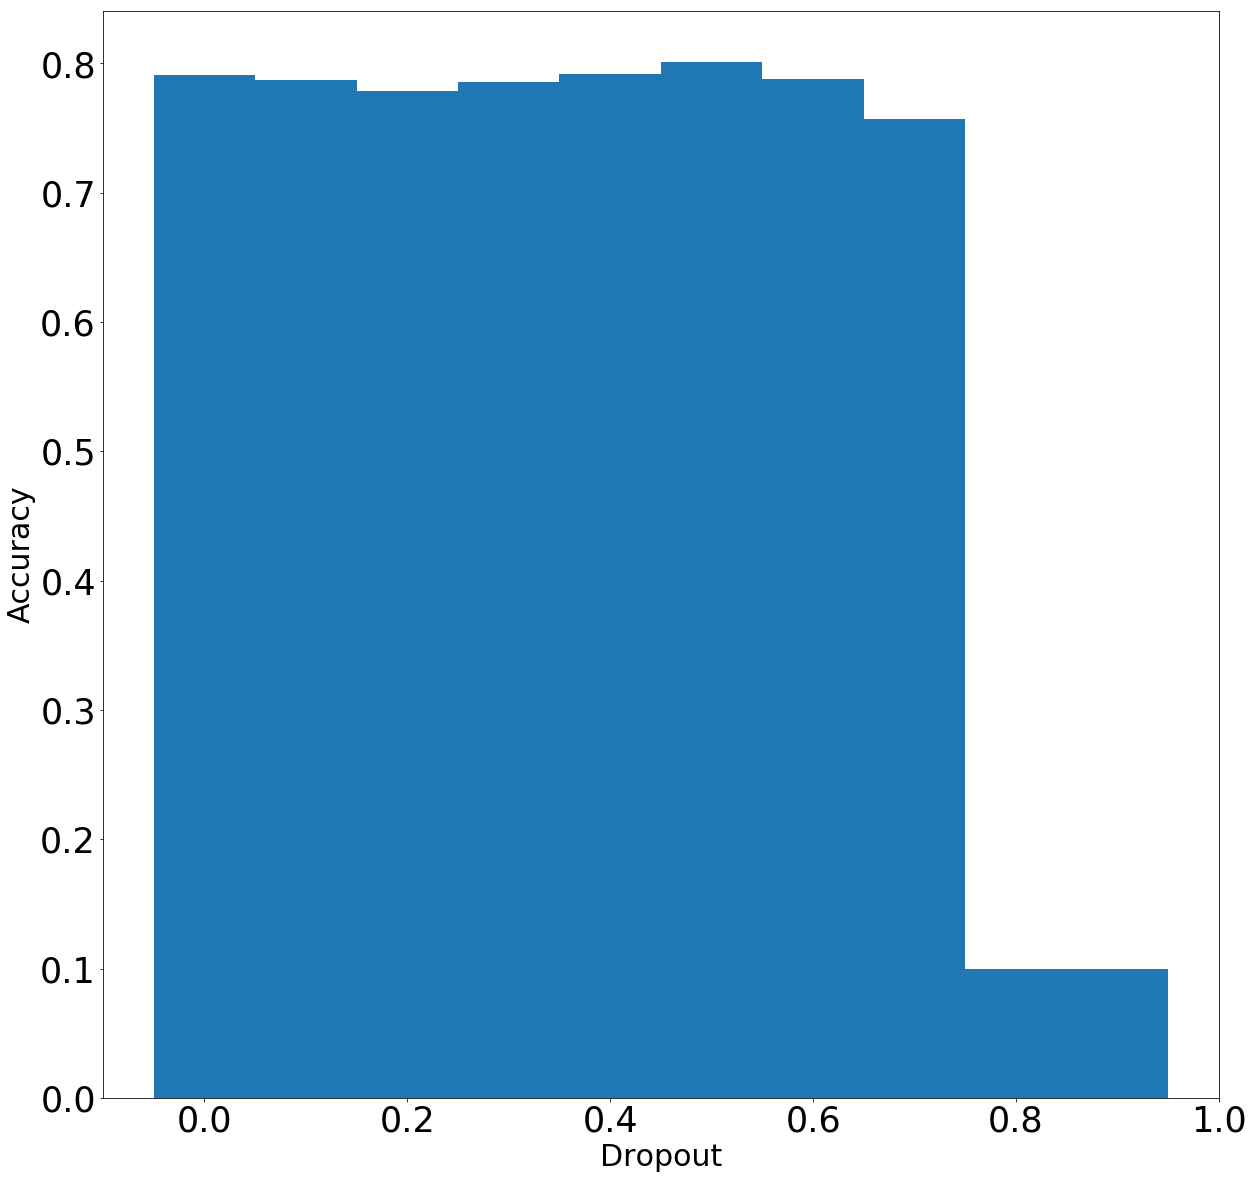

In [0]:
import numpy as np                                                               
import matplotlib.pyplot as plt

width = 0.1

plt.bar(dropouts, acc, width, align='center')

plt.tick_params(axis='both', which='major', labelsize=35)
plt.tick_params(axis='both', which='minor', labelsize=35)

plt.ylabel('Accuracy',size = 30)
plt.xlabel('Dropout', size = 30)
plt.show()

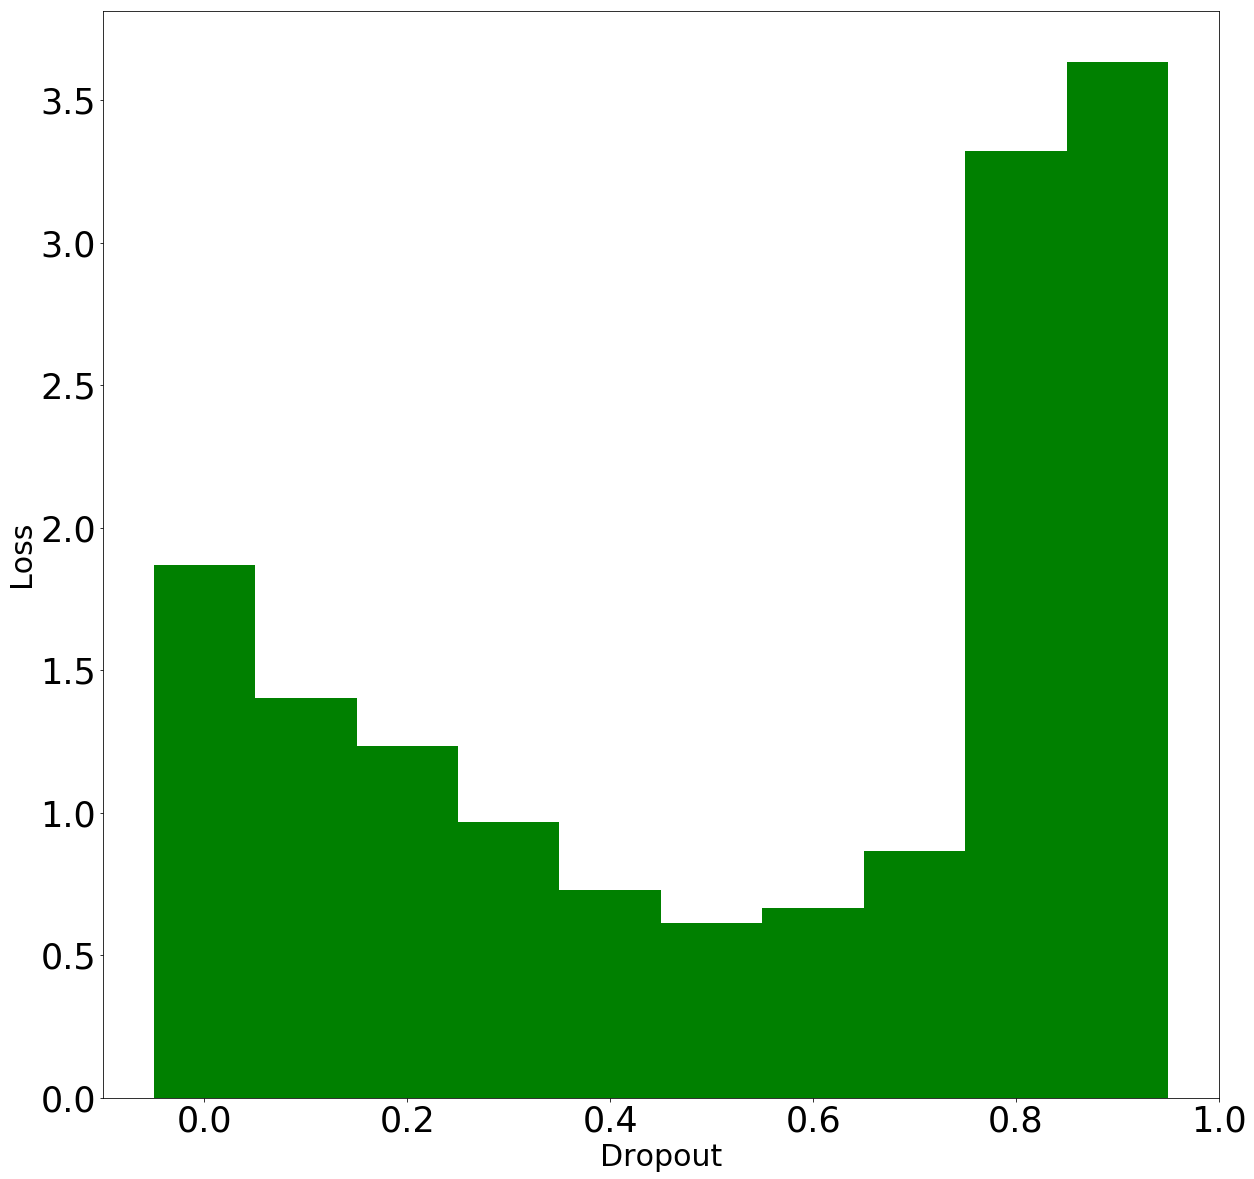

In [0]:
import numpy as np                                                               
import matplotlib.pyplot as plt

width = 0.1

plt.bar(dropouts, loss, width, align='center',color = 'green')

plt.tick_params(axis='both', which='major', labelsize=35)
plt.tick_params(axis='both', which='minor', labelsize=35)

plt.ylabel('Loss',size = 30)
plt.xlabel('Dropout', size = 30)
plt.show()